# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0   486k      0  0:05:42  0:05:42 --:--:--  906k:16  0:02:47 1125kM   35 57.1M    0     0   614k      0  0:04:30  0:01:35  0:02:55  483k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = '../data/cifar10/cifar-10-batches-py'
X_train, y_train, X_val, Y_val, X_test, y_test = load_CIFAR10(cifar10_dir)

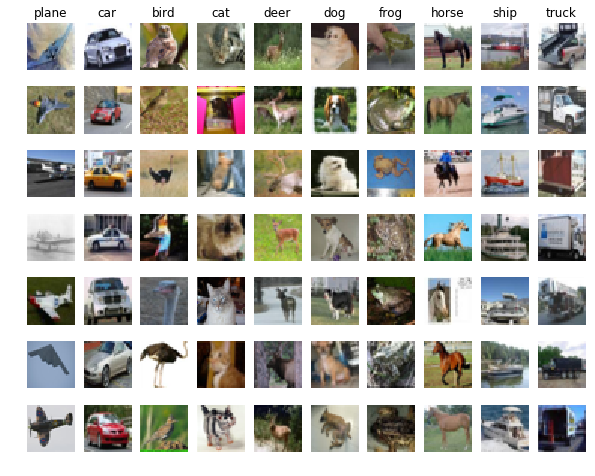

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Значительно большая глубина, прокидывание результатов слоев, batch normalisation, ... 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [7]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne.layers import batch_norm

input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer", dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [37]:
def gen_proto_layer(in_l, n):
    stack1 = batch_norm(lasagne.layers.Conv2DLayer(in_l, n, 3, pad='same')) # сверточный слой
    stack2 = batch_norm(lasagne.layers.Conv2DLayer(stack1, n, 3, pad='same')) # сверточный слой
    layer = lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack1, stack2]))
    
    return layer

In [49]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

# TODO: delete max pooling, add non-linearities

l1 = gen_proto_layer(net, 32)
print("l1", l1.output_shape)
l2 = gen_proto_layer(l1, 64)
print("l2", l2.output_shape)

net = lasagne.layers.MaxPool2DLayer(l2, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)

l3 = gen_proto_layer(net, 128)
print("l3", l3.output_shape)
l4 = gen_proto_layer(l3, 256)
print("l4", l4.output_shape)

net = lasagne.layers.MaxPool2DLayer(l4, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)

net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512)) # полносвязный слой
net = lasagne.layers.DropoutLayer(net, 0.5)                     # регуляризатор
net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512)) # полносвязный слой

net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)

l1 (None, 32, 32, 32)
l2 (None, 64, 32, 32)
l3 (None, 128, 16, 16)
l4 (None, 256, 16, 16)


In [47]:
lasagne.layers.ElemwiseSumLayer?

In [50]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [51]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

# TODO: learning rate schedule
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.001)

In [52]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, 
                            allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [53]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [54]:
import time

num_epochs = 25 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    if num_epochs == 10 or num_epochs == 20:
        batch_size //= 2
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, Y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 25 took 1423.988s
  training loss (in-iteration):		1.426781
  train accuracy:		48.65 %
  validation accuracy:		60.54 %
Epoch 2 of 25 took 1416.279s
  training loss (in-iteration):		0.995256
  train accuracy:		64.34 %
  validation accuracy:		68.18 %
Epoch 3 of 25 took 1415.972s
  training loss (in-iteration):		0.828244
  train accuracy:		70.92 %
  validation accuracy:		71.75 %
Epoch 4 of 25 took 1410.952s
  training loss (in-iteration):		0.724619
  train accuracy:		74.34 %
  validation accuracy:		73.96 %
Epoch 5 of 25 took 1418.368s
  training loss (in-iteration):		0.642148
  train accuracy:		77.47 %
  validation accuracy:		75.87 %
Epoch 6 of 25 took 1414.369s
  training loss (in-iteration):		0.574723
  train accuracy:		79.96 %
  validation accuracy:		75.79 %
Epoch 7 of 25 took 1414.625s
  training loss (in-iteration):		0.519092
  train accuracy:		81.60 %
  validation accuracy:		77.27 %
Epoch 8 of 25 took 1416.268s
  training loss (in-iteration):		0.468677
  train accuracy:		

KeyboardInterrupt: 

In [56]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

GpuArrayException: b'cuMemAlloc: CUDA_ERROR_OUT_OF_MEMORY: out of memory'
Apply node that caused the error: GpuElemwise{sub,no_inplace}(GpuCorrMM{half, (1, 1), (1, 1)}.0, GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[(0, 0)]<gpuarray>.0)
Toposort index: 108
Inputs types: [GpuArrayType<None>(float32, 4D), GpuArrayType<None>(float32, (True, False, True, True))]
Inputs shapes: [(500, 32, 32, 32), (1, 32, 1, 1)]
Inputs strides: [(131072, 4096, 128, 4), (128, 4, 4, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuCAReduceCuda{pre=sqr,red=add}{0, 2, 3}(GpuElemwise{sub,no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 